# PyTorch Model Local Testing

In [40]:
import os
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
import torch.nn as nn
import torch.utils.data

import matplotlib.pyplot as plt

In [41]:
data_dir = 'data'

In [42]:
import torch.nn.functional as F
import torch.nn as nn


class LinearRegressor(nn.Module):

    def __init__(self, input_dim):
        super(LinearRegressor, self).__init__()

        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.output = nn.Linear(64, 1)
        self.dropout = nn.Dropout(p=0.2)
        
#         self.output = nn.Linear(input_dim, 1)
    
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.output(x)
        
#         x = self.output(x)
        
        return x

In [43]:
def train(model, train_loader, validation_loader, epochs, criterion, optimizer, device, early_stop_patience = 10):
    min_validation_loss = float("inf")
    patience = early_stop_patience
    
    for epoch in range(1, epochs + 1):
        model.train() # Make sure that the model is in training mode.

        train_loss = 0

        for batch in train_loader:
            # get data
            batch_x, batch_y = batch

            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            optimizer.zero_grad()

            # get predictions from model
            y_pred = model(batch_x)
            
            # perform backprop
            loss = criterion(y_pred, batch_y)            
            loss.backward()
            
            optimizer.step()
            
            train_loss += loss.item()
        else:    
            model.eval()

            validation_loss = 0

            with torch.no_grad():
                for batch in validation_loader:
                    batch_x, batch_y = batch

                    batch_x = batch_x.to(device)
                    batch_y = batch_y.to(device)

                    # get predictions from model
                    y_pred = model(batch_x)

                    loss = criterion(y_pred, batch_y)

                    validation_loss += loss.item()
                    
            validation_loss /= len(validation_loader)
            
            if validation_loss < min_validation_loss:
                patience = early_stop_patience
                
                print('New validation loss minimum reached. Saving checkpoint')
                
                min_validation_loss = validation_loss
                
                torch.save(model.state_dict(), 'checkpoint.pth')
            else:
                patience -= 1
                
                if patience == 0:
                    print('Early stopping condition reached. Stopping training')
                    
                    break

        print("Epoch: {}, Train loss: {}, Validation loss: {}".format(epoch, train_loss / len(train_loader), validation_loss))

In [44]:
train_data = pd.read_csv(os.path.join(data_dir, 'train.csv'), header=None)
validation_data = pd.read_csv(os.path.join(data_dir, 'validation.csv'), header=None)

In [45]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()

train_data_np = train_data.values
train_data_np_y = train_data_np[:, 0]
train_data_np = min_max_scaler.fit_transform(train_data_np)
train_data_np[:, 0] = train_data_np_y

validation_data_np = validation_data.values
validation_data_np_y = validation_data_np[:, 0]
validation_data_np = min_max_scaler.transform(validation_data_np)
validation_data_np[:, 0] = validation_data_np_y

In [46]:
train_y = torch.from_numpy(train_data_np[:,[0]]).float()
train_x = torch.from_numpy(train_data_np[:,1:]).float()

train_dataset = torch.utils.data.TensorDataset(train_x, train_y)

validation_y = torch.from_numpy(validation_data_np[:,[0]]).float()
validation_x = torch.from_numpy(validation_data_np[:,1:]).float()

validation_dataset = torch.utils.data.TensorDataset(validation_x, validation_y)

In [47]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1000, shuffle=True)
validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=1000, shuffle=True)

In [48]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

In [57]:
model = LinearRegressor(train_x.shape[1])
model.to(device)

lr = 0.001

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

In [58]:
epochs = 300

train(model, train_dataloader, validation_dataloader, epochs, criterion, optimizer, device)

New validation loss minimum reached. Saving checkpoint
Epoch: 1, Train loss: 843259303.4766355, Validation loss: 556914428.3076923
New validation loss minimum reached. Saving checkpoint
Epoch: 2, Train loss: 536134031.7009346, Validation loss: 148743276.30769232
New validation loss minimum reached. Saving checkpoint
Epoch: 3, Train loss: 202468473.79439253, Validation loss: 112412676.61538461
New validation loss minimum reached. Saving checkpoint
Epoch: 4, Train loss: 152573312.0, Validation loss: 99485026.15384616
New validation loss minimum reached. Saving checkpoint
Epoch: 5, Train loss: 132132815.51401868, Validation loss: 85917260.92307693
New validation loss minimum reached. Saving checkpoint
Epoch: 6, Train loss: 114693307.88785046, Validation loss: 75321177.84615384
New validation loss minimum reached. Saving checkpoint
Epoch: 7, Train loss: 99769578.80373831, Validation loss: 65968213.23076923
New validation loss minimum reached. Saving checkpoint
Epoch: 8, Train loss: 8695441

In [51]:
X_test = pd.read_csv(os.path.join(data_dir, 'test.csv'), header=None).values
y_test = pd.read_csv(os.path.join(data_dir, 'test_y.csv'), header=None).values

In [52]:
test_data_np = np.concatenate([y_test, X_test], axis=1)
test_data_np_y = test_data_np[:, 0]
test_data_np = min_max_scaler.transform(test_data_np)
test_data_np[:, 0] = test_data_np_y

In [59]:
test_input = torch.from_numpy(test_data_np[:,1:]).float()

model.eval()

with torch.no_grad():
    predictions = model(test_input.to(device))
    
predictions = predictions.cpu().detach().numpy()
labels = y_test

In [17]:
fig_dir = 'fig'

if not os.path.exists(fig_dir):
    os.mkdir(fig_dir)

Text(0.5, 1.0, 'True Price vs Predicted Price')

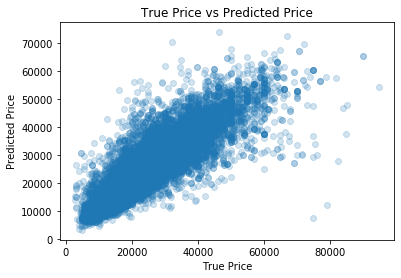

In [60]:
plt.scatter(labels, predictions, alpha=1/5)
plt.xlabel("True price")
plt.ylabel("Predicted price")
plt.title("PyTorch model")
plt.savefig(os.path.join(fig_dir, 'pytorch_pred.jpg'))

In [61]:
from sklearn.metrics import r2_score

score = r2_score(labels, predictions)

print('R-squared score: {}'.format(score))

R-squared score: 0.769561568839065


In [62]:
distances = np.abs(labels - predictions)

max_distance = np.max(distances)
min_distance = np.min(distances)
mean_distance = np.mean(distances)

print('Min distance: {}'.format(min_distance))
print('Max distance: {}'.format(max_distance))
print('Mean distance: {}'.format(mean_distance))

Min distance: 0.08203125
Max distance: 67500.41015625
Mean distance: 3472.263160231912
